# Dog Skin Diseases Classification

The notebook incorporates the model utilized for classifying skin diseases of dogs (3 diseases and 1 healthy class). A customley made datasetspecially for Sri Lanka is used for training, validating and testing the model. The development of the classification model followed a transfer learning approach, using efficientNetB1 Keras application. To assess the performance of the model, several evaluation metrics were employed, including accuracy, F1-score, precision, recall, and evaluation matrix. The output from each metric indicates that the model achieved a high level of accuracy in classifying the eye images.


### Splitting the Dataset 

In [2]:
import splitfolders 


input_folder = r'E:\Year04\IRP\dataset\augmented_datav1'


splitfolders.ratio(input_folder, output='E:\Year04\IRP\dataset\organized_data_augment', 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None) 

Copying files: 12565 files [08:31, 24.56 files/s]


### Importing required libraries

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns
from tensorflow.keras import regularizers

In [9]:
TRAIN_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\train'
VAL_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\val'
TEST_PATH = r'E:\Year04\IRP\dataset\organized_data_augment\test'

### Initializing Image Size

In [10]:
IMAGE_SIZE = (128, 128)

### Initializing train, validation & test data

In [11]:
import tensorflow as tf

# Load datasets
training_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    validation_split=None,
    subset=None,
    shuffle=False,
    batch_size=32,
    image_size=IMAGE_SIZE
)


Found 8795 files belonging to 4 classes.
Found 2513 files belonging to 4 classes.
Found 1257 files belonging to 4 classes.


### Plot Images with labels

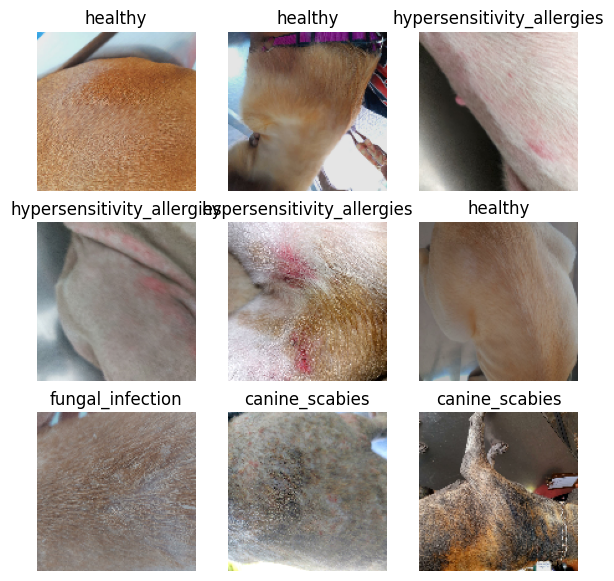

In [12]:
plt.figure(figsize=(7, 7))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(training_ds.class_names[labels[i]])
        plt.axis("off")

In [16]:
class_num = 4
input_shape = (128,128,3)

### Import model for Transfer Learning

In [17]:
efficientnet = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling="avg",
    classes=class_num
)

In [18]:
efficientnet.summary() 

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 128, 128, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                     

### Freeze layerns in EfficientNetB1

In [19]:
for layer in efficientnet.layers[:-15]:
    layer.trainable = False

In [20]:
for layer in efficientnet.layers:
    print(layer.name, layer.trainable)

input_2 False
rescaling_1 False
normalization_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv

### Building the classification model

In [21]:
inputs = tf.keras.Input(shape=input_shape, name='image_input')

x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = efficientnet(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(.4)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(.5)(x)
outputs = Dense(class_num, activation='softmax')(x)

effnet_model = tf.keras.Model(inputs, outputs, name='output')

### Compile the model

In [22]:
effnet_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

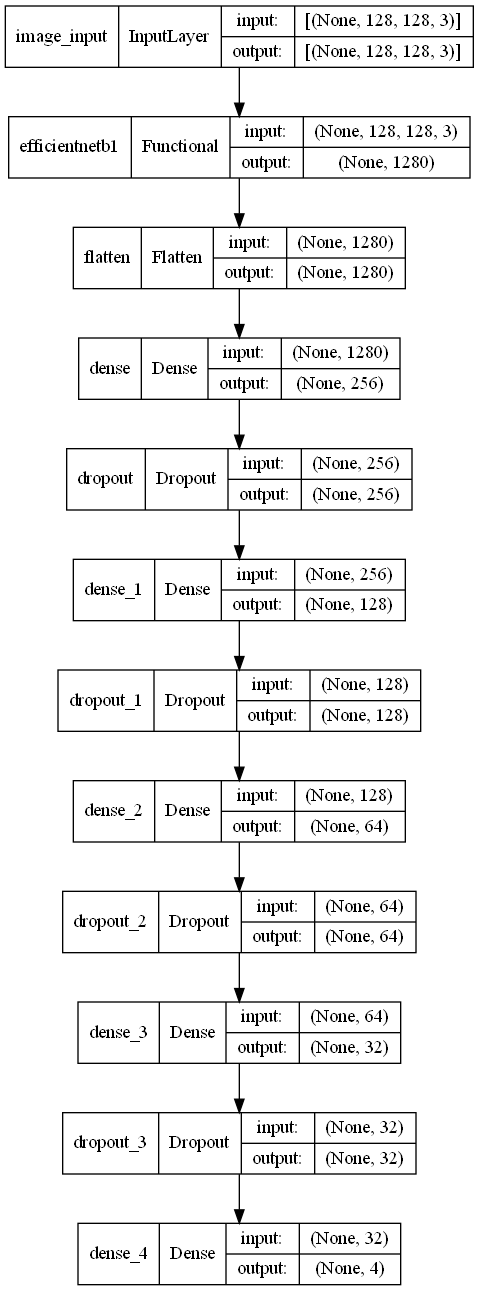

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(effnet_model, to_file='model_eff.png',show_shapes=True, show_layer_names=True)

### Train the model

In [24]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
mc =  ModelCheckpoint('best_model_dogSkinDisease_classification.h5', monitor='val_loss', verbose=1, save_best_only=True)

history_effnet = effnet_model.fit(training_ds, validation_data = val_ds,
          epochs = 30, batch_size = 32, callbacks = [es, mc])


Epoch 1/30
275/275 [==============================] - ETA: 0s - loss: 1.8153 - accuracy: 0.4920
Epoch 00001: val_loss improved from inf to 1.21178, saving model to best_model_dogSkinDisease_classification.h5


c:\anaconda\envs\gpu_py\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


275/275 [==============================] - 214s 735ms/step - loss: 1.8153 - accuracy: 0.4920 - val_loss: 1.2118 - val_accuracy: 0.7819
Epoch 2/30
275/275 [==============================] - ETA: 0s - loss: 1.2527 - accuracy: 0.7570
Epoch 00002: val_loss improved from 1.21178 to 0.86868, saving model to best_model_dogSkinDisease_classification.h5
275/275 [==============================] - 248s 880ms/step - loss: 1.2527 - accuracy: 0.7570 - val_loss: 0.8687 - val_accuracy: 0.8830
Epoch 3/30
275/275 [==============================] - ETA: 0s - loss: 0.9465 - accuracy: 0.8562
Epoch 00003: val_loss improved from 0.86868 to 0.65728, saving model to best_model_dogSkinDisease_classification.h5
275/275 [==============================] - 253s 898ms/step - loss: 0.9465 - accuracy: 0.8562 - val_loss: 0.6573 - val_accuracy: 0.9236
Epoch 4/30
275/275 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.9036
Epoch 00004: val_loss improved from 0.65728 to 0.57268, saving model to bes

### Train, Validation & Test accuracy from saved model

In [25]:
from keras.models import load_model
saved_model = load_model('best_model_dogSkinDisease_classification.h5')

train_loss, train_acc = saved_model.evaluate(training_ds, verbose=0)
val_loss, val_acc = saved_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = saved_model.evaluate(test_ds, verbose=0)


print(f'Accuracy and loss of the best model : ')
print(f'Train accuracy: {train_acc*100:.3f} % || Validation accuracy: {val_acc*100:.3f} % || Test accuracy: {test_acc*100:.3f} %')
print(f'Train loss: {train_loss:.3f} || Validation loss: {val_loss:.3f} || Test loss: {test_loss:.3f}')

Accuracy and loss of the best model : 
Train accuracy: 84.321 % || Validation accuracy: 80.621 % || Test accuracy: 82.657 %
Train loss: 0.701 || Validation loss: 0.908 || Test loss: 0.799


### Plot Accuracy & Loss graphs

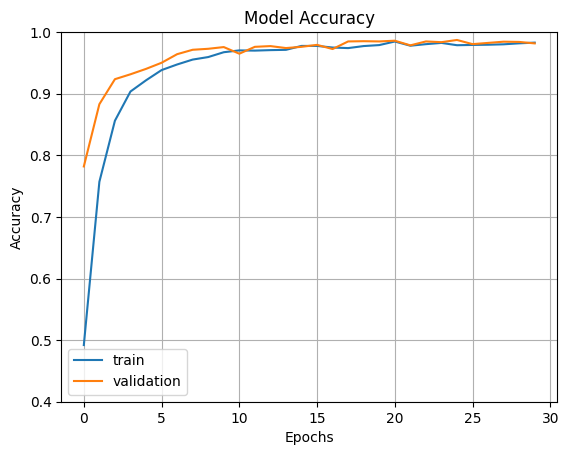

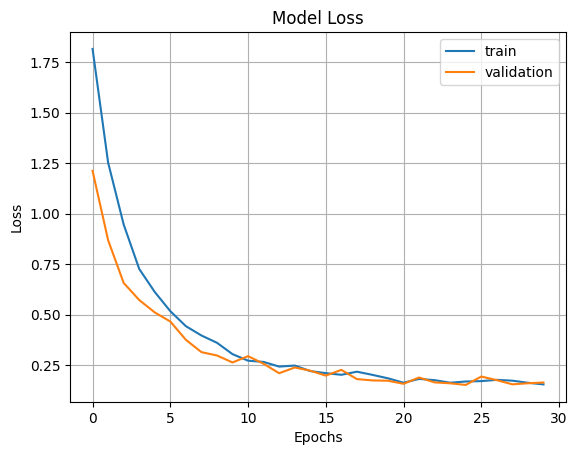

In [26]:
fig1 = plt.gcf()
plt.plot(history_effnet.history['accuracy'])
plt.plot(history_effnet.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


plt.plot(history_effnet.history['loss'])
plt.plot(history_effnet.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Predictions on Test data

In [27]:
prediction_effnet = saved_model.predict(test_ds) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

In [28]:
true_labels = []  

for image_batch, label_batch in test_ds:
    true_labels.append(label_batch)
    
correct_labels = tf.concat([item for item in true_labels], axis = 0)
correct_labels = correct_labels.numpy()

In [29]:
print(type(prediction_effnet))
print(type(correct_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### F1- Score, Precision & Recall

In [30]:
from sklearn.metrics import classification_report

print(classification_report(correct_labels, prediction_effnet))

              precision    recall  f1-score   support

           0       0.98      0.64      0.77       333
           1       0.78      0.84      0.81       344
           2       0.80      0.92      0.86       333
           3       0.80      0.94      0.87       247

    accuracy                           0.83      1257
   macro avg       0.84      0.83      0.83      1257
weighted avg       0.84      0.83      0.82      1257



### Confusion Matrix

<Axes: >

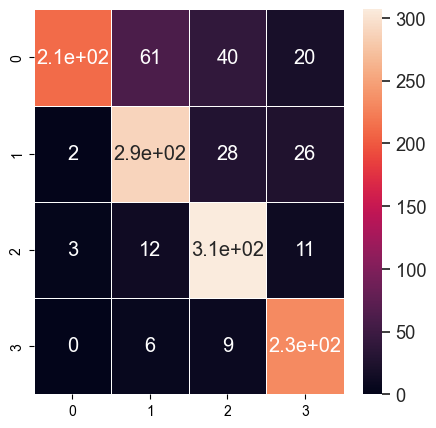

In [31]:
cm = confusion_matrix(correct_labels, prediction_effnet)

fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

### Add labels to an array

In [32]:
class_names = []

for directory in glob.glob("D:/Tasks/Drowsy_Detection/Eyes_Dataset_split/train/*"):
    label = os.path.basename(os.path.normpath(directory))
    class_names.append(label)

print(class_names)

[]


### Using the model for classification

In [3]:
from keras.models import load_model

load_imagePath = 'C:/Users/Athindu/Downloads/gettyimagesn.jpg'
saved_model = load_model('best_model_eye_classification.h5')

<class 'numpy.ndarray'>
[[7.5080606e-20 1.0000000e+00]]
Classification:  Open_Eyes
Value 1.0


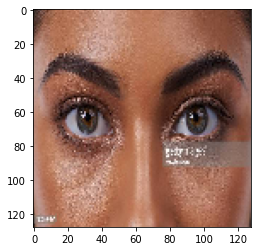

In [10]:
from keras.preprocessing import image

test_img = image.load_img(load_imagePath, target_size = IMAGE_SIZE) 
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
print(type(test_image))    
result = saved_model.predict(test_image)
print(result)
plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])
print("Value", np.amax(result))